## MACS 30250 PS2
### Dr. Richard W. Evans, TA Zunda Xu
### Submitted by Junho Choi

In [107]:
import numpy as np
import pandas as pd
import sympy as sym
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt

### Exercise 2.1

Let us first declare some parameters to be used in the questions.

In [46]:
nvec = np.array([1, 1, 0.2])
A = 1
beta = 0.442
alpha = 0.35
delta = 0.6415
sigma = 3

In [47]:
f_params = (nvec, A, alpha, delta)

In [48]:
bvec_1 = np.array([1.0, 1.2])
bvec_2 = np.array([0.06, -0.001])
bvec_3 = np.array([0.1, 0.1])

Let us now define the `feasible` function.

In [9]:
## for wage calculation
def wage_t(b_2t, b_3t, A=1, alpha=0.35, L_t=2.2):
    rtnval = (1-alpha)*A
    rtnval2 = ((b_2t+b_3t)/L_t) ** alpha
    
    return rtnval * rtnval2

In [12]:
## for interest rate calc.
def rate_t(b_2t, b_3t, A=1, alpha=0.35, delta=0.6415, L_t=2.2):
    rtnval = alpha * A
    rtnval2 = (L_t / (b_2t + b_3t)) ** (1-alpha)
    
    return rtnval * rtnval2 - delta

In [79]:
## for util. function differentiated
def uprime(c, sigma=3):
    if c < 1e-7: ## really small then runtime warning pops up
        return 1e-7 ** (-sigma) -1
    
    return c ** (-sigma) - 1

In [26]:
def feasible(f_params, bvec_guess, beta=0.442):
    nvec, A, alpha, delta = f_params
    b_2, b_3 = bvec_guess
    w = wage_t(b_2, b_3, A, alpha, sum(nvec))
    r = rate_t(b_2, b_3, A, alpha, delta, sum(nvec))
    
    c1 = nvec[0]*w - b_2
    c2 = nvec[1]*w + (1+r)*b_2 - b_3
    c3 = nvec[2]*w + (1+r)*b_3
    
    cbool_1, cbool_2, cbool_3 = c1 >= 0, c2 >= 0, c3 >= 0
    
    bbool_2, bbool_3 = False, False
    
    if cbool_1:
        bbool_2 = True
    
    if cbool_2:
        bbool_2, bbool_3 = True, True
    
    if cbool_3:
        bbool_3 = True
    
    if b_2 + b_3 >= 0:
        K_cnstr = True
    else:
        K_cnstr = False
    
    
    return [bbool_2, bbool_3], [cbool_1, cbool_2, cbool_3], K_cnstr

My first intention was to write the state equations as in the equations of (2.27) and (2.28) in Evans and DeBacker (2019, p. 19), but since we are to check for steady-state cases we can directly solve for $c_1, c_2$, and $c_3$ where the said values are steady-state values. I also assumed that the textbook assignments had the signs flipped, mistakenly; i.e. it should be a nonnegativity condition for both the consumptions and total capital rather than the stated nonpositivity condition.

### 2.1-(a).

In [29]:
feasible(f_params, bvec_1)

([True, True], [False, True, True], True)

As seen above, in this case the first entry the `c_cnstr` is violated, meaning that there is negative consumption in the first stage of life in the steady states.

### 2.1-(b) and 2.1-(c).

In [27]:
feasible(f_params, bvec_2)

([True, True], [True, True, True], True)

In [28]:
feasible(f_params, bvec_3)

([True, True], [True, True, True], True)

As seen above, the cases for both subquestions 2.1-(b) and 2.1-(c) can work. Nonetheless, as these results give out what may be "feasible," we must actually try to solve for the steady state cases (using methods as in the next question) to actually see the steady-state values.

### Exercise 2.2

Let us write the function `get_SS` as directed. Before that, however, I will use some auxiliary functions, including the `uprime` function for differentiated CRRA utility function that I have written above.

In [149]:
def return_ss_consum(w, r, b_2, b_3, nvec=[1, 1, 0.2]):
    c1 = nvec[0]*w - b_2
    c2 = nvec[1]*w + (1+r)*b_2 - b_3
    c3 = nvec[2]*w + (1+r)*b_3
    
    return c1, c2, c3

In [150]:
## to use scipy's root finder, we need to make the Euler error function
def euler_errors(bvec_guess, params):

    beta, sigma, nvec, A, alpha, delta = params
    b_2, b_3 = bvec_guess
    
    w = wage_t(b_2, b_3, A, alpha, L)
    r = rate_t(b_2, b_3, A, alpha, delta, L)
    
    c1, c2, c3 = return_ss_consum(w, r, b_2, b_3, nvec)
    
    euler_error1 = abs(beta*(1+r)*uprime(c2) - uprime(c1))
    euler_error2 = abs(beta*(1+r)*uprime(c3) - uprime(c2))

    return (euler_error1, euler_error2)

In [152]:
## example euler error
params2 = [beta, sigma, nvec, A, alpha, delta]
euler_errors(bvec_3, params2)

(153.1368061202058, 34.13489365932688)

In [153]:
## set some quite small number
SS_tol = 1e-7

def get_SS(params, bvec_guess, SS_graphs=False):

    start_time = time.clock()
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    params_ee = [beta, sigma, nvec, A, alpha, delta]
    result = opt.root(euler_errors, x0=bvec_guess,
                      args=params_ee, tol=SS_tol)
    
    b_ss = result.x
    EulErr_ss = euler_errors(b_ss, params_ee)

    w = wage_t(b_ss[0], b_ss[1], A, alpha, L)
    r = rate_t(b_ss[0], b_ss[1], A, alpha, delta, L)
    
    c_ss = return_ss_consum(w, r, b_ss[0], b_ss[1], nvec)
    C_ss = np.array(c_ss).sum()
    
    K_ss = b_ss.sum()
    Y_ss = A * ((K_ss) ** alpha) * (L ** (1-alpha))
    
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock() - start_time
    
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w, 'r_ss': r,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time
    }
    
    if SS_graphs:
        figure1 = plt.figure(figsize=(10, 4))
        figure1.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, name in enumerate(['c', 'b']):
            plt.subplot(1, 2, i+1)
            if name == 'c':
                plt.bar([1, 2, 3], c_ss, align="center")
                plt.xticks([1, 2, 3], ['Young', 'Middle age', 'Elderly'])
                plt.xlabel("Steady state periods")
                plt.ylabel("Steady state consumptions")
                plt.title("Steady state consumptions")
            else:
                plt.bar([1, 2], b_ss, align="center")
                plt.xticks([1, 2], ['Young to middle age', 'Middle age to elderly'])
                plt.xlabel("Steady state periods")
                plt.ylabel("Steady state savings")
                plt.title("Steady state savings")
    return ss_output

### 2.2-(a) and 2.2-(b)

In [154]:
## setting the parameters
params = (beta, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol)

{'b_ss': array([0.01918916, 0.05811106]),
 'c_ss': (0.1821501997105151, 0.2093157261231943, 0.2404022736698877),
 'w_ss': 0.20133935943804246,
 'r_ss': 2.443998191540742,
 'K_ss': 0.0773002244411662,
 'Y_ss': 0.6814562934826053,
 'C_ss': 0.6318681995035971,
 'EulErr_ss': (4.382914653433545e-08, 5.154406323981675e-08),
 'RCerr_ss': 9.020562075079397e-17,
 'ss_time': 0.0006524999989778735}

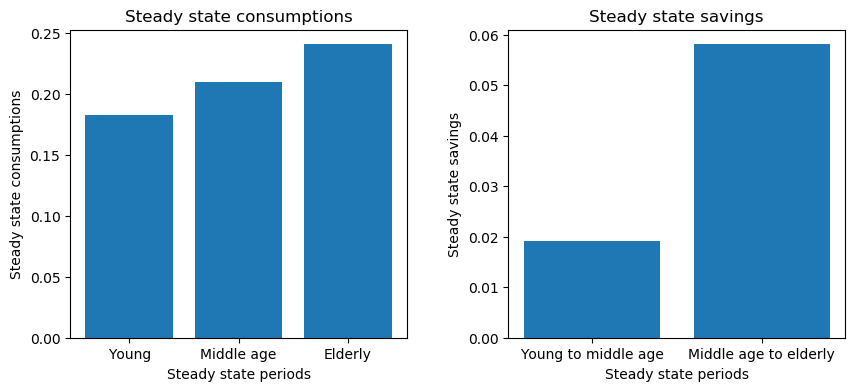

In [155]:
## let's use 2.1-(c)'s initial guess for b.
get_SS(params, bvec_3, True)

In my case, it took me approximately $0.00065$ seconds to compute the steady-state equation. The Euler errors that have been minimized are as follows: $4.38\times10^{-8}$ and $5.15\times10^{-8}$. The resource constraint error was found to be $9.02\times 10^{-17}$, approximately. The bar graphs have been plotted accordingly for consumptions and savings, in which $s=1, 2, 3$ have been interpreted as "young, middle age, and elderly" respectively.

### 2.2-(c)

{'b_ss': array([0.02793225, 0.07632902]),
 'c_ss': [0.19563515188125974, 0.22820474650370748, 0.26596615242837396],
 'w_ss': 0.22356739832631803,
 'r_ss': 1.8986702679115408,
 'K_ss': 0.10426127055393715,
 'Y_ss': 0.7566896558736919,
 'C_ss': 0.6898060508133412,
 'EulErr_ss': (2.6432189770275727e-12, 3.666400516522117e-12),
 'RCerr_ss': -5.551115123125783e-17,
 'ss_time': 0.0003687000062200241}

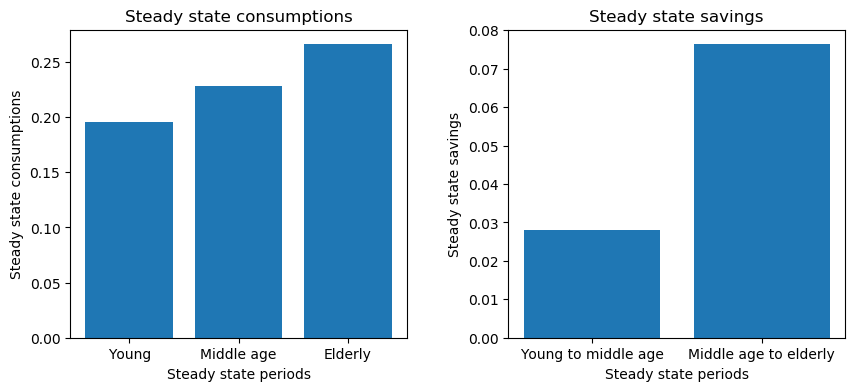

In [121]:
newbeta = 0.55
params_2 = (newbeta, sigma, nvec, nvec.sum(), A, alpha, delta, SS_tol)

get_SS(params_2, bvec_3, True)

As suggested in the question, I have plugged in a new value for $\beta$ to be 0.55, and produced the results accordingly. It is observable that the individuals have saved more, and consumption when in their middle age and elderly periods (i.e. $s=2,3$, but especially for the elderly stage) have become greater. This shows that as $\beta$ is increased (i.e. patience of consumers increase), they are willing to save more in the current period so that their consumption next period can be increased.

Regarding steady-state (SS) wage ($\bar{w}$) and SS rental rate ($\bar{r}$), we see that $\bar{w}$ has increased but $\bar{r}$ has decreased. From the firm's perspective, now that there is more capital in the economy to be utilized (from more saving), labor has become scarce in relation to capital. Therefore, due to this scarcity in production, the relative prices adjust so that wage increases and rental rate of capital decreases.

### Exercise 2.3

### 2.3-a.

Let us use the SS result that we found in Exercise 2.2 to start things off.

In [128]:
prev = get_SS(params, np.array([0.1, 0.1]), False)
b_ss = prev['b_ss']
K_ss = prev['K_ss']

The non-SS case was to be initialized as follows: $b_{2, 1} = 0.8\bar{b}_2$ and $b_{3, 1} = 1.1\bar{b}_3$, respectively.

In [156]:
b2_init, b3_init = b_ss[0] * 0.8, b_ss[1] * 1.1 
K_init = b2_init + b3_init
b_init = np.array([b2_init, b3_init])

Since $T<50$, let us put $T=49$ just in case. Also, $\epsilon$ is to be initialized as $10^{-9}$. I also "guess" that $\zeta$ to be 0.5.

In [131]:
T, eps, zeta = 49, 1e-9. 0.5

Let us assume that the transition path is linear (which is unlikely to be true).

In [159]:
K_init_path = np.linspace(K_init, K_ss, T)
K_init_path

array([0.0792735 , 0.07923239, 0.07919128, 0.07915017, 0.07910906,
       0.07906795, 0.07902684, 0.07898573, 0.07894462, 0.07890351,
       0.0788624 , 0.07882129, 0.07878018, 0.07873907, 0.07869796,
       0.07865685, 0.07861574, 0.07857463, 0.07853352, 0.07849241,
       0.0784513 , 0.07841019, 0.07836908, 0.07832797, 0.07828686,
       0.07824575, 0.07820464, 0.07816353, 0.07812242, 0.07808131,
       0.0780402 , 0.07799909, 0.07795798, 0.07791687, 0.07787576,
       0.07783465, 0.07779354, 0.07775243, 0.07771132, 0.07767021,
       0.0776291 , 0.07758799, 0.07754688, 0.07750577, 0.07746466,
       0.07742355, 0.07738244, 0.07734133, 0.07730022])

We also need the path of wages and rates for convenience's sake.

In [163]:
w_path = wage_t(K_init_path * 0.5, K_init_path * 0.5)
r_path = rate_t(K_init_path * 0.5, K_init_path * 0.5) ## since it only depends on aggregates.

We try to make the single iteration of this path. But first, we need to know what the next period's saving is going to be (i.e. $b_{3,t+1}$) for the currently-middle-aged. We modify the Euler error function for this.

In [172]:
## to use scipy's root finder, we need to make the Euler error function
def euler_error_b32(b32, params):
    
    w_path, r_path, beta, t, b = params
    b21, b31 = b
    
    euler_error = uprime(w_path[t]*(1+r_path[t])*b21 - b32) \
                  - beta * (1+r_path[t+1]) * uprime(0.2 * w_path[t+1] + (1+r_path[t+1])*b31)

    return euler_error

In [193]:
def path_b32(r_path, w_path, beta, t, b_init):
    finder = opt.root(euler_error_b32, b_init[1],
             [r_path, w_path, beta, t, b_init], tol=eps)  
    b32_optimized = finder.x
    return b32_optimized

Let's make the total Euler error function. Again, we modify the previous Euler error function with the return_ss_consum used.

In [178]:
def euler_errors_2(bvec_guess, params):
    beta, w, r, t = params
    b_2, b_3 = bvec_guess
    
    c1 = 1*w[t] - b_2
    c2 = 1*w[t+1] + (1+r[0])*b_2 - b_3
    c3 = 0.2*w[t+2] + (1+r[1])*b_3
    
    euler_error1 = beta*(1+r[t])*uprime(c2) - uprime(c1)
    euler_error2 = beta*(1+r[t+1])*uprime(c3) - uprime(c2)

    return (euler_error1, euler_error2)

We can make one iteration of the time path iteration.

In [186]:
def one_tpi(b_init, params, eps=eps, T=49):

    b_paths = np.zeros((T+1, 2))
    b_paths[0, :] = b_init
    
    for t in range(T):
        finder = opt.root(euler_errors_2, b_init,
                          params, tol=eps)
        b21, b32 = finder.x
        b_paths[t, 0], b_paths[t+1, 1] = b21, b32
    
    return b_paths

Let us now attempt the entire TPI.

In [200]:
maxiter = 1000
dist = np.inf
zeta = 0.5

w_ = w_path.copy()
r_ = r_path.copy()

K_act = np.append(K_init_path, K_ss)
K_prime = K_act.copy()

bvec_guess = b_init.copy()
for i in range(maxiter):
    if dist < eps:
        break
    b_path = one_tpi(bvec_guess, [beta, w_, r_, 0])
    b_path[T, 0] = path_b32(r_, w_, beta, 0, bvec_guess)
    
    K_prime[1:T+1] = b_path.sum(axis=1)[0:T]
    dist = ((K_prime - K_act) ** 2).sum() ## l2 norm
    K_next_act = zeta * K_prime + (1-zeta) * K_act
    
    K_next_act = K_act.copy()
    w_ = wage_t(K_next_act, 0)
    r_ = rate_t(K_next_act, 0)

### 2.3-(b)

Unfortunately, due to coding error, I was not able to make the values converge; I plot the graphs nonetheless (K, r, and w).

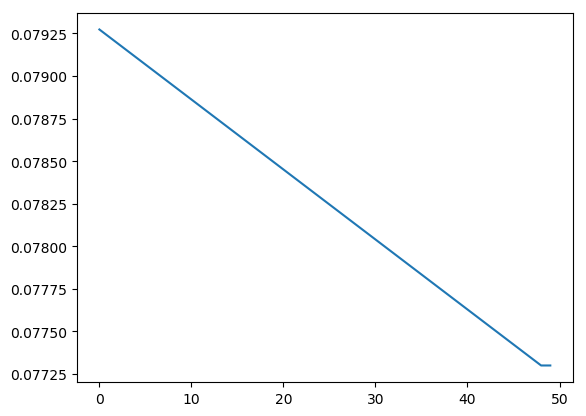

In [214]:
## interest rate
plt.plot(range(0, K_next_act.shape[0]), K_next_act)

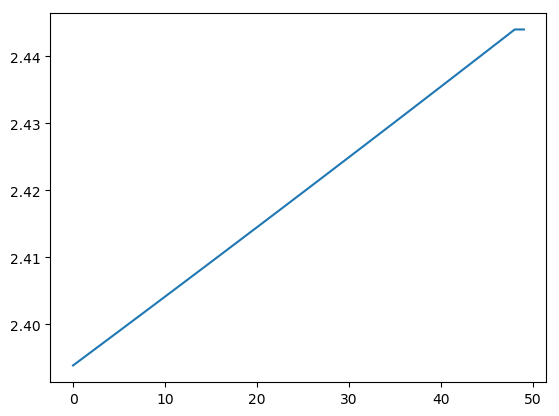

In [218]:
## interest rate
plt.plot(range(0, r_.shape[0]), r_)
plt.show()

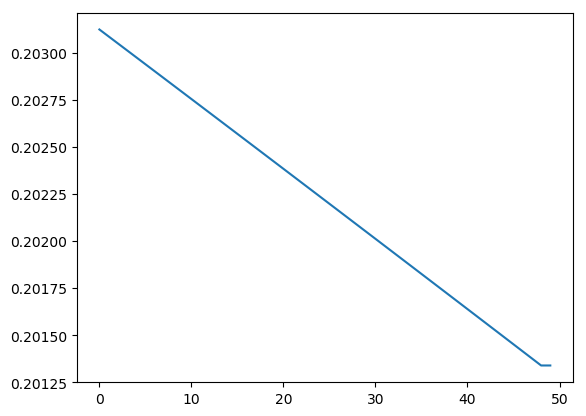

In [213]:
plt.plot(range(0, w_.shape[0]), w_)

### 2.3-(c)
Unfortunately, I was not able to make the code converge; I believe that I may have made a coding mistake.

In [205]:
dist

3.226735991789107e-05